<a href="https://colab.research.google.com/github/khalit7/Deep_Q_Network/blob/main/deep_Q_network_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install baselines --no-deps

     |████████████████████████████████| 123 kB 4.9 MB/s 
  Created wheel for baselines: filename=baselines-0.1.5-py3-none-any.whl size=163902 sha256=ba50a101d5f58854696973e5e97670bc8660ca33b049da4bdb64a5d30b08d865
  Stored in directory: /root/.cache/pip/wheels/64/27/40/3b266f230c825e6b219bfdd5447566d4d109b66fc4e0c074ed
Successfully built baselines


In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!python -m atari_py.import_roms "/content/drive/MyDrive/game_ai/roms"

copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domurat, Steve Woita) (CX2696) (Prototype).bin to /usr/local/lib/python3.7/dist-packages/a

#base line implementation

In [ ]:
"""
Title: Deep Q-Learning for Atari Breakout
Author: [Jacob Chapman](https://twitter.com/jacoblchapman) and [Mathias Lechner](https://twitter.com/MLech20)
Date created: 2020/05/23
Last modified: 2020/06/17
Description: Play Atari Breakout with a Deep Q-Network.
"""
"""
## Introduction
This script shows an implementation of Deep Q-Learning on the
`BreakoutNoFrameskip-v4` environment.
This example requires the following dependencies: `baselines`, `atari-py`, `rows`.
They can be installed via:
```
git clone https://github.com/openai/baselines.git
cd baselines
pip install -e .
git clone https://github.com/openai/atari-py
wget http://www.atarimania.com/roms/Roms.rar
unrar x Roms.rar .
python -m atari_py.import_roms .
```
### Deep Q-Learning
As an agent takes actions and moves through an environment, it learns to map
the observed state of the environment to an action. An agent will choose an action
in a given state based on a "Q-value", which is a weighted reward based on the
expected highest long-term reward. A Q-Learning Agent learns to perform its
task such that the recommended action maximizes the potential future rewards.
This method is considered an "Off-Policy" method,
meaning its Q values are updated assuming that the best action was chosen, even
if the best action was not chosen.
### Atari Breakout
In this environment, a board moves along the bottom of the screen returning a ball that
will destroy blocks at the top of the screen.
The aim of the game is to remove all blocks and breakout of the
level. The agent must learn to control the board by moving left and right, returning the
ball and removing all the blocks without the ball passing the board.
### Note
The Deepmind paper trained for "a total of 50 million frames (that is, around 38 days of
game experience in total)". However this script will give good results at around 10
million frames which are processed in less than 24 hours on a modern machine.
### References
- [Q-Learning](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf)
- [Deep Q-Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)
"""
"""
## Setup
"""

from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

# Use the Baseline Atari environment because of Deepmind helper functions
env = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

"""
## Implement the Deep Q-Network
This network learns an approximation of the Q-table, which is a mapping between
the states and actions that an agent will take. For every state we'll have four
actions, that can be taken. The environment provides the state, and the action
is chosen by selecting the larger of the four Q-values predicted in the output layer.
"""

num_actions = 4


def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()


"""
## Train
"""
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 10000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()



In [ ]:
#load everything
episode_reward_history = np.load("/content/drive/MyDrive/game_ai/checkpoint/episode_reward_history_8.npy").tolist()

model = keras.models.load_model('/content/drive/MyDrive/game_ai/checkpoint/model_8.h5')
model_target = keras.models.load_model('/content/drive/MyDrive/game_ai/checkpoint/model_target_8.h5')


In [ ]:
model.compile(optimizer=optimizer,loss=loss_function)
model_target.compile(optimizer=optimizer,loss=loss_function)
epsilon=0.1

In [ ]:
while frame_count<2000000:
    state = np.array(env.reset())
    episode_reward = 0
    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and only after the buffer is full
        if frame_count % update_after_actions == 0 and len(done_history) >= max_memory_length :

            # Get indices of samples for replay buffers 
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # # Q value = reward + discount factor * expected future reward
            # updated_q_values = rewards_sample + gamma * tf.reduce_max(
            #     future_rewards, axis=1
            # )

            # # If final frame set the last value to -1
            # updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            updated_q_values = rewards_sample + (1-done_sample)*gamma*tf.reduce_max(
                future_rewards,axis=1
            )

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "updating target network, running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))
            # save everything
            print("the average reward during the last 100 episonds = {}".format(running_reward))
            print("saving on episode {} ".format(episode_count))
            model.save('/content/drive/MyDrive/game_ai/checkpoint/model_9.h5')
            model_target.save("/content/drive/MyDrive/game_ai/checkpoint/model_target_9.h5")
            np.save("/content/drive/MyDrive/game_ai/checkpoint/episode_reward_history_9",episode_reward_history)

    #

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if (len(episode_reward_history)<100):
      running_reward = np.mean(episode_reward_history) 
    else:
      running_reward = np.mean(episode_reward_history[-100:])
      
    episode_count += 1


updating target network, running reward: 8.11 at episode 36, frame count 10000
the average reward during the last 100 episonds = 8.11
saving on episode 36 
updating target network, running reward: 8.56 at episode 79, frame count 20000
the average reward during the last 100 episonds = 8.56
saving on episode 79 
updating target network, running reward: 7.93 at episode 121, frame count 30000
the average reward during the last 100 episonds = 7.93
saving on episode 121 
updating target network, running reward: 7.19 at episode 168, frame count 40000
the average reward during the last 100 episonds = 7.19
saving on episode 168 
updating target network, running reward: 7.28 at episode 207, frame count 50000
the average reward during the last 100 episonds = 7.28
saving on episode 207 
updating target network, running reward: 7.71 at episode 251, frame count 60000
the average reward during the last 100 episonds = 7.71
saving on episode 251 
updating target network, running reward: 8.26 at episode

## Moving average plot

In [6]:
# first we load the rewards
episode_reward_history = np.load("/content/drive/MyDrive/game_ai/checkpoint/episode_reward_history_9.npy").tolist()

In [26]:
window = 100
start = 0
moving_avg=[]
while start + window <= len(episode_reward_history) :
  moving_avg.append(np.mean(episode_reward_history[start:start+window]))
  start +=window

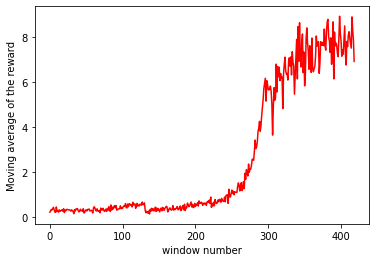

In [36]:
plt.plot(moving_avg,color="red")
plt.xlabel('window number')
plt.ylabel('Moving average of the reward')
plt.savefig('moving_avg.png')